In [1]:
from MEG import *
from mshr import *

In [2]:
# domain 
mesh = generate_mesh(Circle(Point(0., 0.), 1.), 200) # Unit circle, h=diameter/200

In [3]:
freq    = 4 * (2 * np.pi)      # frequency 
Lbd     = 1.0                  # default value = 1.0 to simulate Absorbing Boundary Condition.
dim     = 2                    # default value = 2.

epsilon = Constant(1)          # Background Coefficients
mu      = Constant(1.0)
sigma   = Constant(0.0000)

In [4]:
# Default values
class Arg(object):
    pass

args = Arg()
args.frequency    = freq
args.permittivity = epsilon 
args.permeability = mu
args.conductivity = sigma 

args.Lambda       = Lbd
args.mesh         = mesh 
args.dim          = dim 

args.scalar_elem  = 'CG'
args.vector_elem  = 'N1curl'
args.deg          = 2

In [5]:
args.dbc          = None
args.ibc          = lambda x: True    # Boundary is Impedance Boundary Condition.

In [6]:
# Set source and impedance to default values.
args.source_r     = Constant((0., 0.))
args.source_c     = Constant((0., 0.))
args.imp_r        = Constant((0., 0.))
args.imp_c        = Constant((0., 0.))

m = MEG(args)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


/usr/lib/python3/dist-packages/FIAT/check_format_variant.py:9: DeprecationWarning: Variant of Nedelec element will change from point evaluation to integral evaluation. You should project into variant="integral"
  warnings.warn('Variant of ' + element + ' element will change from point evaluation to integral evaluation.'


In [7]:
dataX = [(0.15, 0.3, 0.2, 0.5)]
dataY = [(-0.35, 0.5, 0.2, 0.2)]
class SourceFunctionVector(UserExpression):
    def eval(self, values, x):
        for item in dataX:
            x0, y0, r, amp = item
            if (x[0] - x0)**2 + (x[1] - y0)**2 < r**2:
                values[0] = amp * (1 + cos(sqrt( (x[0] - x0)**2 + (x[1] - y0)**2  ) * np.pi / r))
            else:
                values[0] = 0
                
        for item in dataY:
            x0, y0, r, amp = item
            if (x[0] - x0)**2 + (x[1] - y0)**2 < r**2:
                values[1] = amp * (1 + cos(sqrt( (x[0] - x0)**2 + (x[1] - y0)**2  ) * np.pi / r))
            else:
                values[1] = 0
                

In [8]:
# The source is actually 1J * Frequency * SourceFunction.
# Impedance is zero to simulate Absorbing Boundary Condition.

m.source_c = args.frequency * SourceFunctionVector(element = m.vector_space.ufl_element())

In [9]:
A, b = m.construct_variational_form()

In [10]:
# Solve for E = Er + i Ec. 
Er, Ec = m.solve(A, b)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


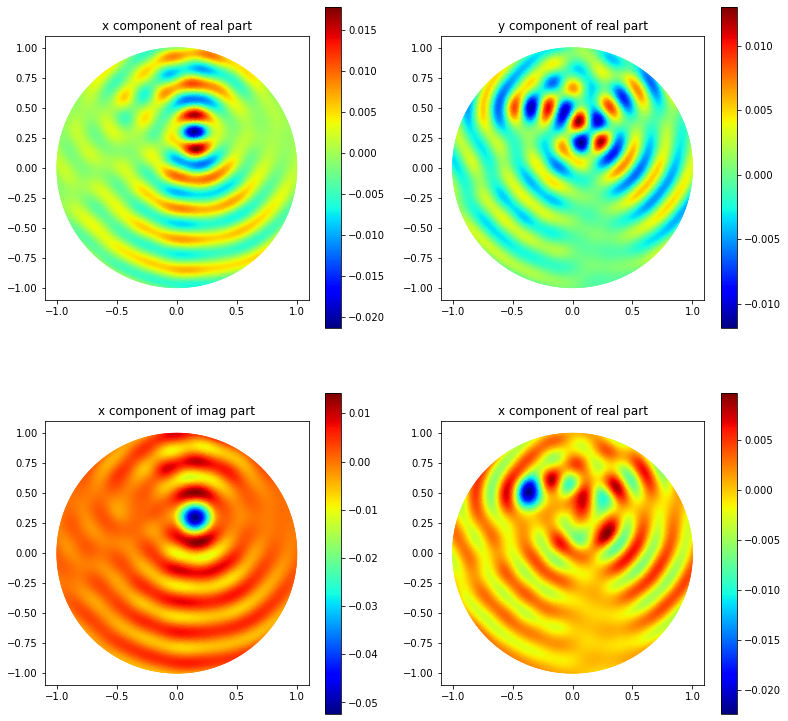

In [11]:
plt.figure(figsize=(13,13))
m.visualize(Er, Ec)
plt.show()
interactive(True)

In [12]:
# Construct Auxillary Solutions.

# Mute the sources.
m.source_c = Constant((0., 0.))

# Construct the impedance.
m.imp_r = args.frequency * Expression(('x[1] * sin(omega * x[1])', \
                                       '-x[0] * sin(omega * x[1])'), \
                                      degree = 4, omega = args.frequency)

# Compute the projection onto Trace (See the definition of Trace function in MEG).
m.imp_c = args.frequency * Expression(('x[1] * x[1] * cos(omega * x[1])', \
                                       '-x[1] * x[0] * cos(omega * x[1])'), \
                                      degree = 4, omega = args.frequency)

In [13]:
A, b = m.construct_variational_form()

In [14]:
Fr, Fc = m.solve(A, b)

Calling FFC just-in-time (JIT) compiler, this may take some time.


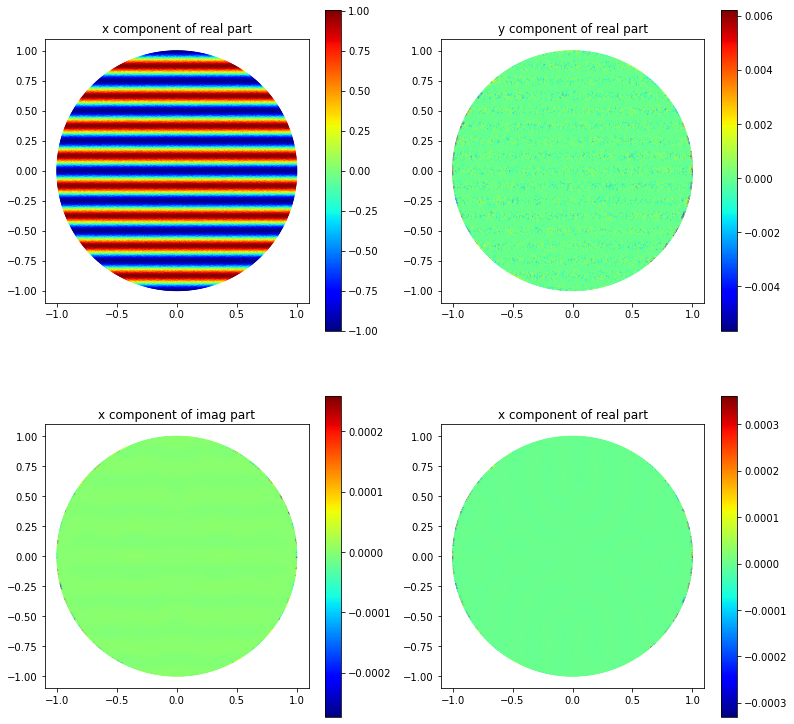

In [15]:
plt.figure(figsize=(13,13))
m.visualize(Fr, Fc)
plt.show()
interactive(True)